In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
from tqdm import tqdm

import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable

from regressCNN import RegressionPCA

/home/dgist/miniconda3/envs/HSE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Device Check

In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda_available else 'cpu')

print('cuda available:', cuda_available)
print('using device', device)

cuda available: True
using device cuda:0


### Dataset Configuration

In [4]:
def repeat_data(x):
    row, col = x.shape
    data = np.zeros([row, col+2])
    data[:, 0] = x[:, -1]
    data[:, 1:-1] = x
    data[:, -1] = x[:, 0]
    return data

def _transform(x):
    return repeat_data(x.transpose())

In [5]:
class HSEDataset(Dataset):
    def __init__(self, data_path, transform=_transform):
        self.frontal = []
        self.lateral = []
        self.shape = []

        self.transform = transform

        for dir in tqdm(os.listdir(data_path), desc='loading data'):
            path = os.path.join(data_path, dir)
            f = np.load(os.path.join(path, 'frontal.npy'))
            l = np.load(os.path.join(path, 'lateral.npy'))
            s = np.load(os.path.join(path, 'shape.npy'))

            self.frontal.append(f)
            self.lateral.append(l)
            self.shape.append(s)

    def __getitem__(self, i):
        f = self.frontal[i]
        l = self.lateral[i]
        s = self.shape[i]

        if self.transform:
            f = self.transform(f)
            l = self.transform(l)
        return f, l, s

    def __len__(self):
        return len(self.frontal)

### Training Configuration

In [6]:
batch_size = 256
learning_rate = 1e-5
training_epoch = 1

In [9]:
train_dataset = HSEDataset('/home/dgist/datasets/HSE/sample_648/train/')
test_dataset = HSEDataset('/home/dgist/datasets/HSE/sample_648/test/')

train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print('train dataloader len:', len(train_data_loader))

loading data: 100%|██████████| 886/886 [00:01<00:00, 885.46it/s]

train dataloader len: 32


In [10]:
model = RegressionPCA(22).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

### Training

In [11]:
gender='male'
loss_train_epoch1 = []
loss_train = []

checkpoint_path = './model/checkpoint_{}/'.format(time.ctime().replace(' ', '_'))
os.mkdir(checkpoint_path)

pbar = tqdm(range(1, training_epoch+1), desc='epoch', leave=False)

for epoch in pbar:
    loss_n = 0
    
    for i, data_temp in enumerate(train_data_loader):
        # read data from data_loader, get 32 data each time
        front_e_ith, side_e_ith, shape_ith = data_temp
        front_e_ith, side_e_ith, shape_ith = \
            front_e_ith.to(device, dtype = torch.float), \
                side_e_ith.to(device, dtype = torch.float), \
                    shape_ith.to(device, dtype = torch.float)
        
        # feed data and forward pass
        outputs = model(front_e_ith, side_e_ith)
        #********************************************************************************************
        
        loss = criterion(outputs, shape_ith.float())
        loss_n += loss.item()
        #********************************************************************************************
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == 1:
            loss_train_epoch1.append(loss)
    
    loss_n /= len(train_data_loader)

    pbar.set_description(f'epoch:{epoch} | TrainLoss:{loss_n:.6f}')
    loss_train.append(loss_n)
    
    if epoch%50 == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_path, f'{gender}_{epoch}.ckpt'))

### Training Result

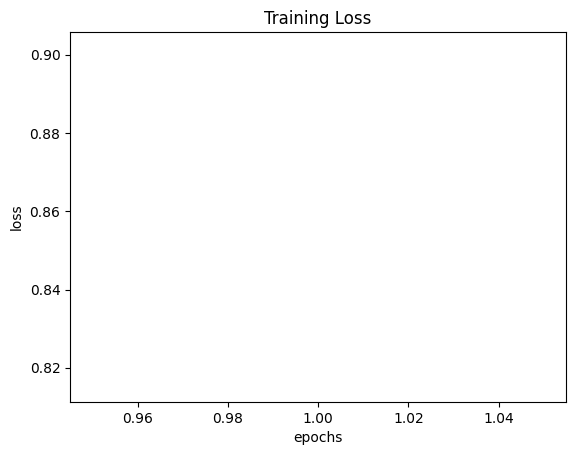

In [12]:
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.plot(range(1, training_epoch+1), loss_train)
plt.show()

In [ ]:
plt.title('Training Loss at epoch=1')
plt.xlabel('iterations')
plt.ylabel('loss')

plt.plot(loss_train_epoch1)
plt.show()